# Machine Learning Fraud Detection: A Simple Machine Learning Approach
## Introduction
The PwC global economic crime survey of 2016 suggests that approximately 36% of organizations experienced economic crime. Therefore, there is definitely a need to solve the problem of credit card fraud detection. The task of fraud detection often boils down to outlier detection, in which a dataset is scanned through to find potential anomalies in the data. In the past, this was done by employees  which checked all transactions manually. With the rise of machine learning, artificial intelligence, deep learning and other relevant fields of information technology, it becomes feasible to automate this process and to save some of the intensive amount of labor that is put into detecting credit card fraud. In the following sections, my machine learning based Pythonic approach is explained.

In [24]:
# !pip install pandas scikit-learn seaborn
%matplotlib inline

### Gather and First Glance at the Data
The very first step is to gather the data.

In [62]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
data = pd.read_csv('creditcard.csv')

# Show the contents
print(data)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
5            2.0  -0.425966   0.960523  1.141109 -0.168252  0.420987   
6            4.0   1.229658   0.141004  0.045371  1.202613  0.191881   
7            7.0  -0.644269   1.417964  1.074380 -0.492199  0.948934   
8            7.0  -0.894286   0.286157 -0.113192 -0.271526  2.669599   
9            9.0  -0.338262   1.119593  1.044367 -0.222187  0.499361   
10          10.0   1.449044  -1.176339  0.913860 -1.375667 -1.971383   
11          10.0   0.384978   0.616109 -0.874300 -0.094019  2.924584   
12          10.0   1.249999  -1.221637  0.383930 -1.234899 -1.48

Apparently, the data consists of 28 variables (V1, …, V28), an “Amount” field a “Class” field and the “Time” field. We do not know the exact meanings of the variables (due to privacy concerns). The Class field takes values 0 (when the transaction is not fraudulent) and value 1 (when a transaction is fraudulent). The data is unbalanced: the number of non-fraudulent transactions (where Class equals 0) is way more than the number of fraudulent transactions (where Class equals 1). Furthermore, there is a Time field. Further inspection shows that these are integers, starting from 0.

There is a small trick for getting more information than only the raw records. We can use the following code:

print(df.describe())

This code will give a statistically summary of all the columns. It shows for example that the Amount field ranges between 0.00 and 25691.16. Thus, there are no negative transactions in the data.

In [63]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

### Normalization
Notice that some of the variables have a wide range of values (like the Amount variable). In order to get all variables in an equivalent range, we subtract the mean and divide by the standard deviation such that the distribution of the values is normalized:

In [64]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

### Seaborn visualization

It would seem from the below Seaborn visualization that transactions of class 1 (orange) are of comparatively low values.

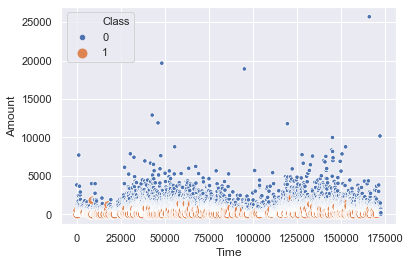

In [65]:
sns.set()

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="Time", y="Amount",
                     hue="Class", size="Class",
                     sizes=(80, 20), hue_norm=(0, 7),
                     legend="full", data=data)



### Splitting the data
It would be unfair to train a Machine Learning algorithm on the data and then test the approach on the same data. If you do that, then memorization could be used to achieve optimal performance: just remember all the data that is seen and by that you can perfectly know what to answer on the same dataset. A problem arises when data is unknown. The memorization technique can by no means predict a label for unseen data. We will split the data in a train set and a test set. The Machine Learning algorithm is then trained on the train set and its performance is computed by letting it predict labels on the test set. The test set is unseen data for the algorithm: it was not shown to the algorithm before.

This is not the only problem. Another problem is that we are dealing with unbalanced data. Luckily, the scikit-learn library provides us some tools for splitting the unbalanced data fairly.

### Model
As a model, I will use Logistic Regression. This model is often used in problems with binary target variables. Our Class variable is indeed a binary variable. It is not the best approach, but at least it offers some insights in the data.

Select the features we would like to use during the training:

In [66]:
# Only use the 'Amount' and 'V1', ..., 'V28' features
features = ['Amount'] + ['V%d' % number for number in range(1, 29)]

# The target variable which we would like to predict, is the 'Class' variable
target = 'Class'

# Now create an X variable (containing the features) and an y variable (containing only the target variable)
X = data[features]
y = data[target]

Notice that some of the variables have a wide range of values (like the Amount variable). In order to get all variables in an equivalent range, we subtract the mean and divide by the standard deviation such that the distribution of the values is normalized:


In [67]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar by subtracting the mean and by dividing by the standard deviation.
    """
    for feature in X.columns:
        X[feature] -= X[feature].mean()
        X[feature] /= X[feature].std()
    return X

Okay, now it is time for some action! We will first define the model (the Logistic Regression model) and then loop through a train and test set which have approximately the same Class distribution. First, we train the model by the train set and then validate the results with the test set. The StratisfiedShuffleSplit makes sure that the Class variable has roughly the same distribution in both the train set and the test set. The random state specification makes sure that the result is deterministic: in other words, we will get the same results if we would run the analysis again. The normalization is done for both the train set and test set. If this was done before the split, some information of the test set would be used in the normalization of the train set and this is not fair since the test set is not completely unseen then. The following code does the job:

In [68]:
# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(X, y):
    # Select the train and test data
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    
    # Normalize the data
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    
    # Fit and predict!
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # And finally: show the results
    print(classification_report(y_test, y_pred))

/Users/johanjgenis/.virtualenvs/chatfin/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/johanjgenis/.virtualenvs/chatfin/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/johanjgenis/.virtualenvs/chatfin/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142158
           1       0.88      0.61      0.72       246

    accuracy                           1.00    142404
   macro avg       0.94      0.81      0.86    142404
weighted avg       1.00      1.00      1.00    142404



This is actually a great result! The 0 classes (transactions without fraud) are predicted with 100% precision and recall. It has some issues with detecting the 1 classes (transactions which are fraudulent). It can predict fraud with 88% precision. This means that 12% of the transactions which are fraudulent remain undetected by the system. But, 88% is still quite good!